In [1]:
import datetime as dt
import os

import numpy as np

from coropy import simulate

In [2]:
# data
DATA_PATH = os.path.join(os.pardir, 'data')
COUNTRY = 'CRO'
DATA = os.path.join(DATA_PATH, COUNTRY)
CONFIRMED_CASES_PATH = os.path.join(
    DATA_PATH, COUNTRY, 'confirmed_cases.dat')
RECOVERED_CASES_PATH = os.path.join(
    DATA_PATH, COUNTRY, 'recovered_cases.dat')
DEATH_CASES_PATH = os.path.join(
    DATA_PATH, COUNTRY, 'death_cases.dat')
TESTS_PATH = os.path.join(
    DATA_PATH, COUNTRY, 'tests.dat')

confirmed_cases = np.loadtxt(CONFIRMED_CASES_PATH)
recovered_cases = np.loadtxt(RECOVERED_CASES_PATH)
death_cases = np.loadtxt(DEATH_CASES_PATH)
daily_tests = np.loadtxt(TESTS_PATH)
removed_cases = recovered_cases + death_cases
active_cases = confirmed_cases - removed_cases

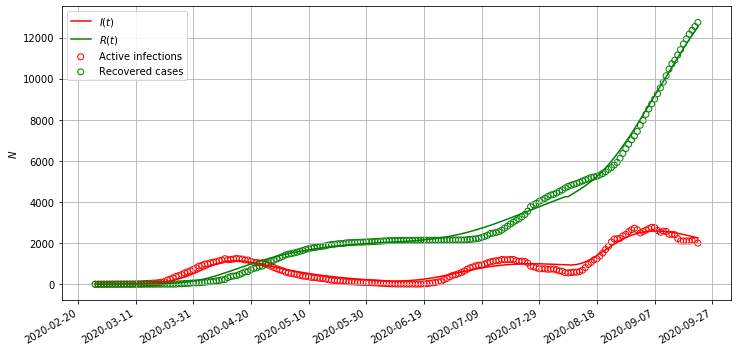

In [3]:
(S, E, I, R) = simulate.seir_multiple_waves(
    active_cases=active_cases, 
    removed_cases=recovered_cases,
    first_wave_eff_population=2200,
    eff_dates=[dt.datetime(2020, 2, 26),
               dt.datetime(2020, 6, 9),
               dt.datetime(2020, 8, 8)],
    plot_sim=True)

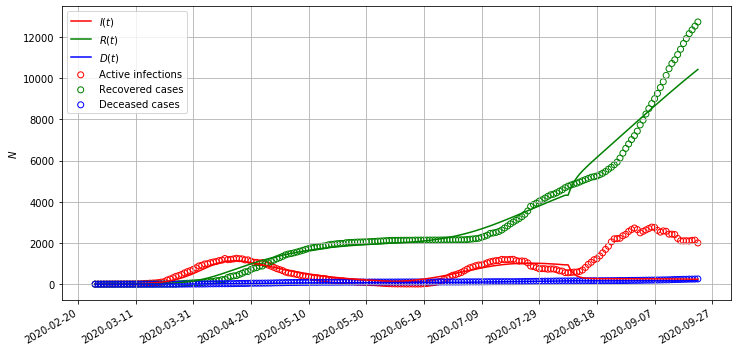

In [4]:
(S, E, I, R, D) = simulate.seird_multiple_waves(
    active_cases=active_cases, 
    recovered_cases=recovered_cases,
    death_cases=death_cases,
    first_wave_eff_population=2200,
    eff_dates=[dt.datetime(2020, 2, 26),
               dt.datetime(2020, 6, 9),
               dt.datetime(2020, 8, 8)],
    plot_sim=True)